# FV400 Algorithm Simulator for EMC Analysis

Specification:  
FV400 Algorithm Simulator for EMC Analysis - B - 18 Feb 19.docx

In [1]:
%matplotlib inline

#######################################
## PROCESS LOG FILE HELPER FUNCTIONS ##
#######################################

def getBiasVoltages(iBv):
    # Expecting a byte value e.g. 99 cast as int (153)
    FlMask = 0xF0 # mask for the flame voltage bias i.e. 11110000
    FRshift = 4 # number of right shifts e.g. start with 0x99, end with 0x09
    GMask = 0x0F # mask for the guard voltage bias, no need to shift
    iFbv = (iBv & FlMask) >> FRshift 
    iGbv = iBv & GMask 
    return iFbv, iGbv

def getAlarmGainSpikeCount(iEvent):
    # Byte 6:  EVENT (MSB-LSB: Alarm\Gain\0\Spike\Count\Count\Count\Count) -check
    # Alarm = bit 7
    # Gain = bit 6
    # Spike = bit 4
    # Count = bits 0,1,2,3
    # Notes; count is a sequential 4 bit count, expected to be continuous and
    # carry over o 15, restarting at 0. If any values are found to be missing, action
    # might be required, e.g. linear interpolation to patch missing observations
    AMask = 0x80 # 10000000
    ARshift = 7
    GMask = 0x40 # 01000000
    GRshift = 6
    SMask = 0x10 # 00010000
    SRshift = 4
    CMask = 0x0F # 00001111
    # no shift required for count
    Alarm = (iEvent & AMask) >> ARshift
    Gain = (iEvent & GMask) >> GRshift
    Spike = (iEvent & SMask) >> SRshift
    Count = (iEvent & CMask)
    return Alarm, Gain, Spike, Count

def processLog(filePath, filename):
    # expected return values are
    # FlameA, FlameB, Guard, Flame A&B bias voltage, Alarm (true/false), Gain(true/false)
    # Spike(true/false) and Count(4 bit running count)
    import numpy as np
    # vars
    # expected record length
    iRecLen = 12
    # initialise empty return array
    retarr = np.empty((0,9), dtype='uint8')

    logfilename = filePath + filename
    file = open(logfilename, "r")
    for line in file:
        line = line.rstrip()
        if((len(line) == iRecLen) & (line.find(" ") < 0)):
            # FlameA, FlameB and Guard detector analogue readings
            iFAv = int(line[0:2], 16)
            iFBv = int(line[2:4], 16)
            iG = int(line[4:6], 16)
            iBv = int(line[6:8], 16)
            iFbv, iGbv = getBiasVoltages(iBv)
            iEvent = int(line[10:12], 16)
            Alarm, Gain, Spike, Count = getAlarmGainSpikeCount(iEvent)            
            retarr = np.append(retarr, [[iFAv, iFBv, iG, iFbv, iGbv, Alarm, Gain, Spike, Count]],axis = 0)
    return retarr

def getLogfiles(path, pattern):
    # return a list of files
    import glob
    files = []
    for name in glob.glob(path + pattern):
        files.append(name[len(path):])
    return files

def spikePolygon(farr, plt):
    import numpy as np    
    Sidx = 7 # alarm flag index
    iSize = farr[0:,0].size 
    # y axys polygon edges
    maxY = np.max([np.max(farr[:,0]), np.max(farr[:,1])])
    minY = np.min([np.min(farr[:,0]), np.min(farr[:,1])])
    yPol = [minY,maxY,maxY,minY]
    for i in range(iSize):
        # check if Alarm polygon needs to be plotted
        if ((farr[i,Sidx] == 1) & ((i+1) <= iSize)):
            xPol = [i, i, i+1, i+1]
            plt.fill(xPol, yPol, '#0200fe')
            
def alarmPolygon(farr, plt):
    import numpy as np    
    Aidx = 5 # alarm flag index
    iSize = farr[0:,0].size 
    # y axys polygon edges
    #maxY = np.max(farr[:,0])
    #minY = np.min(farr[:,0])
    maxY = np.max([np.max(farr[:,0]), np.max(farr[:,1])])
    minY = np.min([np.min(farr[:,0]), np.min(farr[:,1])])    
    yPol = [minY,maxY,maxY,minY]
    for i in range(iSize):
        # check if Alarm polygon needs to be plotted
        if ((farr[i,Aidx] == 1) and ((i+1) <= iSize)):
            xPol = [i, i, i+1, i+1]
            plt.fill(xPol, yPol, '#fe0002')

def plotFlamedata(farr, file):
    %matplotlib inline
    import matplotlib.pyplot as plt
    import numpy as np
    # indices
    FAidx = 0
    FBidx = 1
    Gidx = 2
    # x axis time series array
    iIdx = np.arange(1, farr[:,0].size + 1, 1) # iIdx = np.arange(1, iGlfd.size + 1, 1)
    plt.clf()
    figWidthScale = 66 # 1150 points for every 18 inches
    figHeight = 10
    figWidth = 18 # small format # farr[:,FAidx].size / figWidthScale # about 484 inches for a 30 second capture
    plt.figure(figsize=(figWidth,figHeight))
    plt.plot(iIdx, farr[:,FAidx], label='FlameA')
    plt.plot(iIdx, farr[:,FBidx], label='FlameB')
    plt.plot(iIdx, farr[:,Gidx], label='Guard')
    # fill spike state indicator bar
    spikePolygon(farr, plt)
    # Fill Alarm state indicator bar
    alarmPolygon(farr, plt)    
    plt.xlabel('Time(ms)')
    plt.ylabel('AD values')
    plt.title("Flame data - " + file)
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=1)
    plt.show()     

### Suppress Spike function  
  
$$ Sp(x) = 1 \equiv Fd(x_{i,k}) > T $$  
  
$$ Fd(x_{i,k}) = \Delta F_{i,k} \cdot S_{i,k} $$  
  
$$ \Delta F_{i,k} = \Bigg| \sum_{x=i}^kFa_{x} - \sum_{x=i}^kFb_{x} \Bigg| $$ 
  
$$ S_{i,k} = \frac{Ymax}{Fmax_{i,k} - Fmin_{i,k} }$$   
  
$$ Fmax_{i,k} = \frac{max \Big( \big[Fa_{i}, Fa_{k}\big]\Big) + max \Big(\big[Fb_{i}, Fb_{k}\big]\Big)}{2} $$  
  
$$ Fmin_{i,k} = \frac{min \Big( \big[Fa_{i}, Fa_{k}\big]\Big) + min \Big(\big[Fb_{i}, Fb_{k}\big]\Big)}{2} $$  
  
Where:   
$T$ = threshold  
$Fa, Fb$ = detector analogue values

In [2]:
def getScallingFactor(k, farr, FAidx, FBidx, Gidx, xint, GScallingFactor, SpkRegSize):
    # get y max, min range over x interval 
    # return scalling factor to max y (254)
    Ymax = 255 
    if(k < xint):
        xint = k;
    fmx = (max(farr[k-xint:k, FAidx]) + max(farr[k-xint:k, FBidx])) / 2
    fmin = (min(farr[k-xint:k, FAidx]) + min(farr[k-xint:k, FBidx])) / 2
    fabs = int(Ymax / (fmx - fmin)) 
    # subtract deltaG to account for Guard noise
    # compute deltaG function
    #gInterval = (SpkRegSize * 100) 
    #deltaG = 0
    #if(k >= gInterval):
    #    deltaG = max(farr[k-gInterval:k, Gidx]) - min(farr[k-gInterval:k, Gidx])   
        # deltaG 3
    #if(deltaG < 1):
    #    deltaG == 0
    #fabs -= deltaG
    if(fabs == 0):
        fabs = 1
    # print('fmx: %d fmin: %d fabs: %d' % (fmx, fmin, fabs))
    return fabs

********************************************************
** SUMMARY TABLE - 15Dec10 1122 3-17.5k-28k-1k-3k.log **
********************************************************
Recorded Spikes | Recorded Alarms | Calculated Spikes | Almost Alarms (5oo2) | Calculated Alarms (5oo3)
18               | 1829               | 20                 | 1                    | 18                        
sFactor: 3 distFunc * sFactor: 390 gDist: 19
sFactor: 3 distFunc * sFactor: 294 gDist: 18
sFactor: 3 distFunc * sFactor: 303 gDist: 19
sFactor: 3 distFunc * sFactor: 330 gDist: 16
sFactor: 3 distFunc * sFactor: 348 gDist: 25
sFactor: 3 distFunc * sFactor: 330 gDist: 28
sFactor: 2 distFunc * sFactor: 240 gDist: 33
sFactor: 2 distFunc * sFactor: 172 gDist: 17
sFactor: 2 distFunc * sFactor: 204 gDist: 23
sFactor: 2 distFunc * sFactor: 216 gDist: 17
sFactor: 2 distFunc * sFactor: 242 gDist: 23
sFactor: 2 distFunc * sFactor: 214 gDist: 33
sFactor: 2 distFunc * sFactor: 224 gDist: 26
sFactor: 2 distFunc * sFactor

<Figure size 432x288 with 0 Axes>

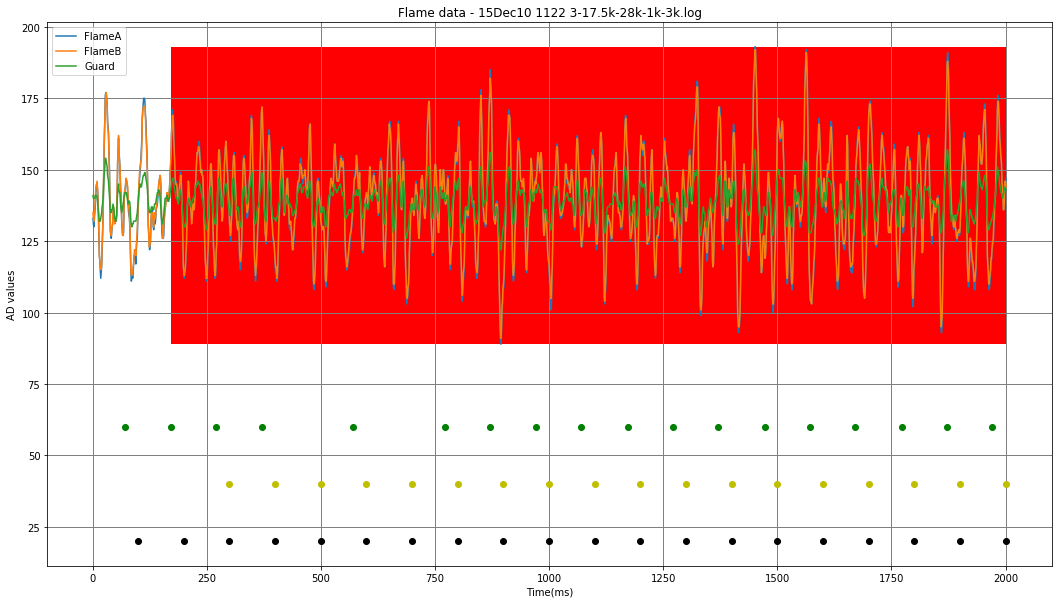

*****************************************
** SUMMARY TABLE - 15Dec10 1437 37.log **
*****************************************
Recorded Spikes | Recorded Alarms | Calculated Spikes | Almost Alarms (5oo2) | Calculated Alarms (5oo3)
58               | 6501               | 53                 | 9                    | 57                        
sFactor: 5 distFunc * sFactor: 395 gDist: 12
sFactor: 5 distFunc * sFactor: 370 gDist: 7
sFactor: 5 distFunc * sFactor: 490 gDist: 10
sFactor: 7 distFunc * sFactor: 609 gDist: 6
sFactor: 6 distFunc * sFactor: 522 gDist: 11
sFactor: 6 distFunc * sFactor: 528 gDist: 10
sFactor: 6 distFunc * sFactor: 474 gDist: 8
sFactor: 6 distFunc * sFactor: 474 gDist: 15
sFactor: 6 distFunc * sFactor: 468 gDist: 7
sFactor: 6 distFunc * sFactor: 570 gDist: 8
sFactor: 6 distFunc * sFactor: 504 gDist: 7
sFactor: 9 distFunc * sFactor: 891 gDist: 8
sFactor: 10 distFunc * sFactor: 990 gDist: 10
sFactor: 7 distFunc * sFactor: 714 gDist: 11
sFactor: 7 distFunc * sFactor: 560 

<Figure size 432x288 with 0 Axes>

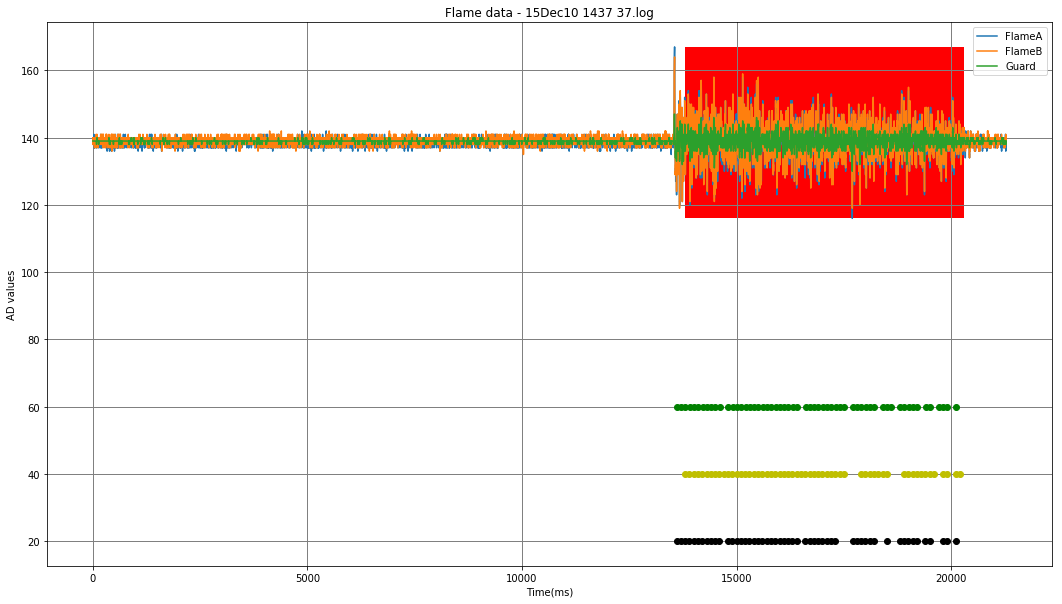

******************************************
** SUMMARY TABLE - Test45-1.2k-2.3k.log **
******************************************
Recorded Spikes | Recorded Alarms | Calculated Spikes | Almost Alarms (5oo2) | Calculated Alarms (5oo3)
6               | 600               | 5                 | 2                    | 5                        
sFactor: 1 distFunc * sFactor: 15 gDist: 2
sFactor: 1 distFunc * sFactor: 114 gDist: 26
sFactor: 1 distFunc * sFactor: 72 gDist: 10
sFactor: 1 distFunc * sFactor: 75 gDist: 3


<Figure size 432x288 with 0 Axes>

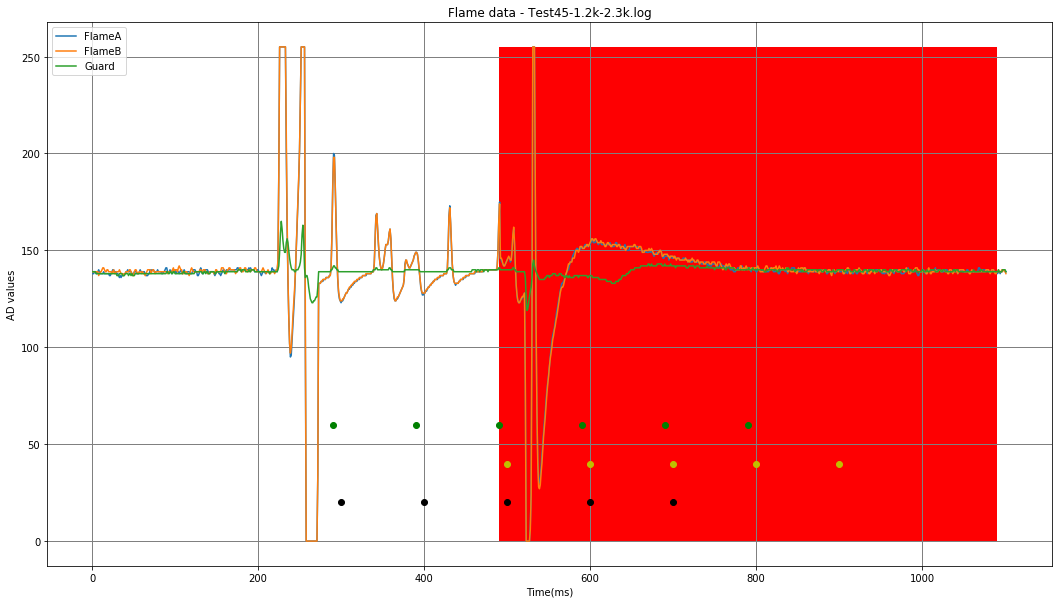

********************************************************************
** SUMMARY TABLE - Test45-scripting-engine-no-headers-footers.log **
********************************************************************
Recorded Spikes | Recorded Alarms | Calculated Spikes | Almost Alarms (5oo2) | Calculated Alarms (5oo3)
0               | 0               | 0                 | 0                    | 0                        


<Figure size 432x288 with 0 Axes>

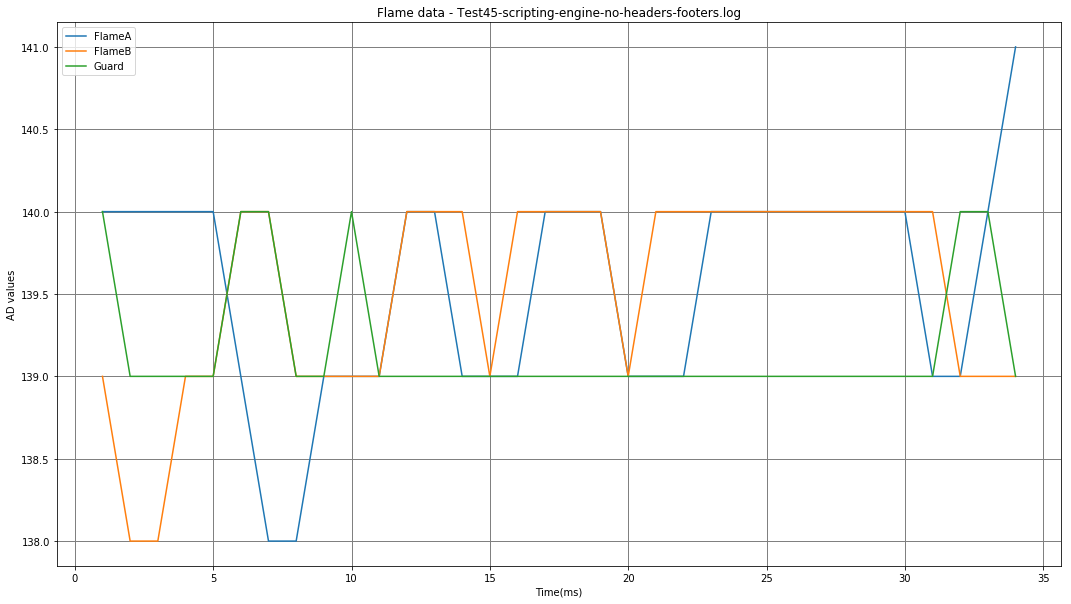

*************************************************
** SUMMARY TABLE - Test45-scripting-engine.log **
*************************************************
Recorded Spikes | Recorded Alarms | Calculated Spikes | Almost Alarms (5oo2) | Calculated Alarms (5oo3)
0               | 0               | 0                 | 0                    | 0                        


<Figure size 432x288 with 0 Axes>

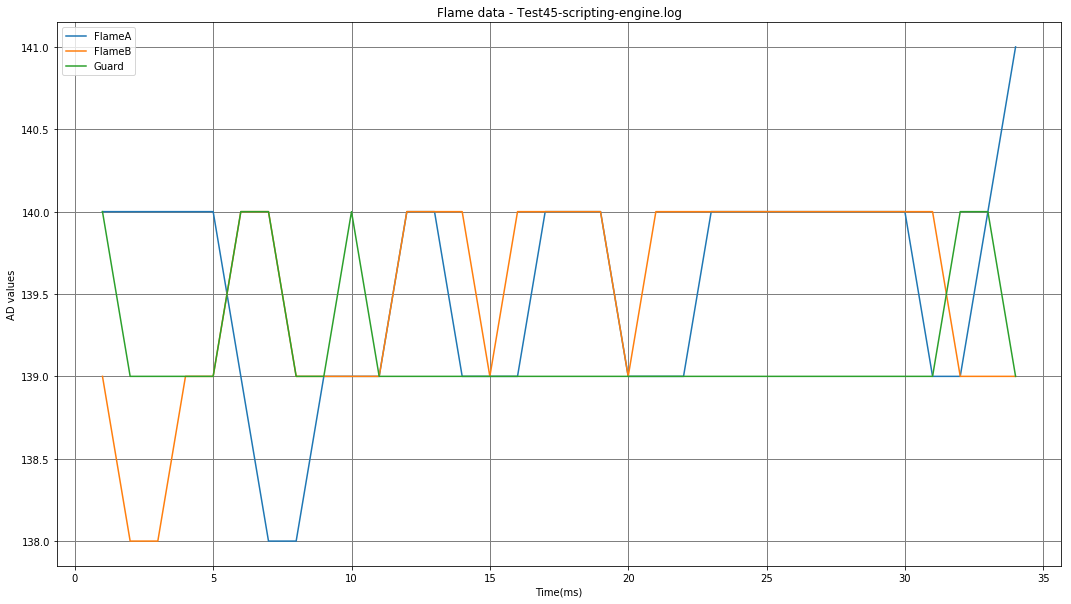

********************************
** SUMMARY TABLE - Test45.log **
********************************
Recorded Spikes | Recorded Alarms | Calculated Spikes | Almost Alarms (5oo2) | Calculated Alarms (5oo3)
6               | 600               | 5                 | 2                    | 5                        
sFactor: 1 distFunc * sFactor: 15 gDist: 2
sFactor: 1 distFunc * sFactor: 114 gDist: 26
sFactor: 1 distFunc * sFactor: 72 gDist: 10
sFactor: 1 distFunc * sFactor: 75 gDist: 3


<Figure size 432x288 with 0 Axes>

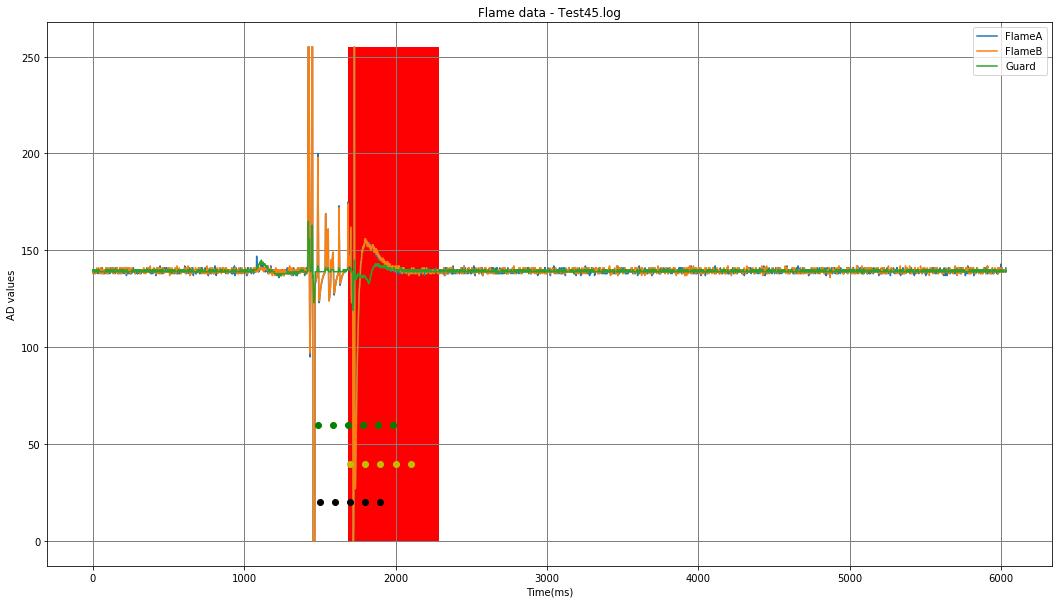

**************************************************
** SUMMARY TABLE - Test46-11k-16k-1.5k-2.1k.log **
**************************************************
Recorded Spikes | Recorded Alarms | Calculated Spikes | Almost Alarms (5oo2) | Calculated Alarms (5oo3)
3               | 163               | 3                 | 3                    | 2                        
sFactor: 7 distFunc * sFactor: 1862 gDist: 1


<Figure size 432x288 with 0 Axes>

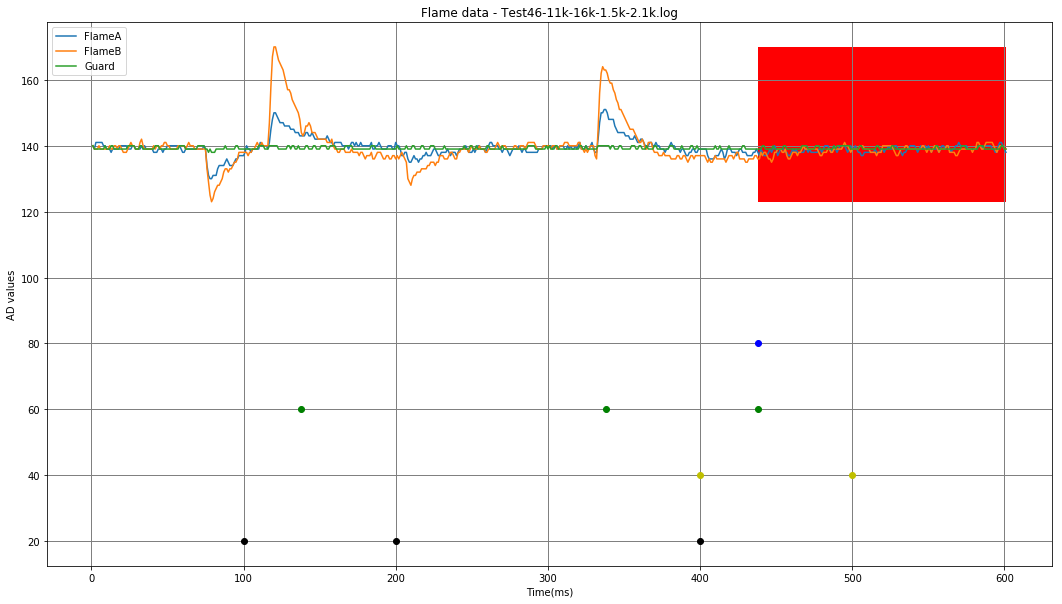

****************************************
** SUMMARY TABLE - Test46-11k-16k.log **
****************************************
Recorded Spikes | Recorded Alarms | Calculated Spikes | Almost Alarms (5oo2) | Calculated Alarms (5oo3)
15               | 1100               | 11                 | 14                    | 3                        
sFactor: 7 distFunc * sFactor: 1862 gDist: 1
sFactor: 6 distFunc * sFactor: 1002 gDist: 1
sFactor: 6 distFunc * sFactor: 1848 gDist: 2
sFactor: 8 distFunc * sFactor: 2000 gDist: 1
sFactor: 4 distFunc * sFactor: 1432 gDist: 3
sFactor: 9 distFunc * sFactor: 2538 gDist: 3


<Figure size 432x288 with 0 Axes>

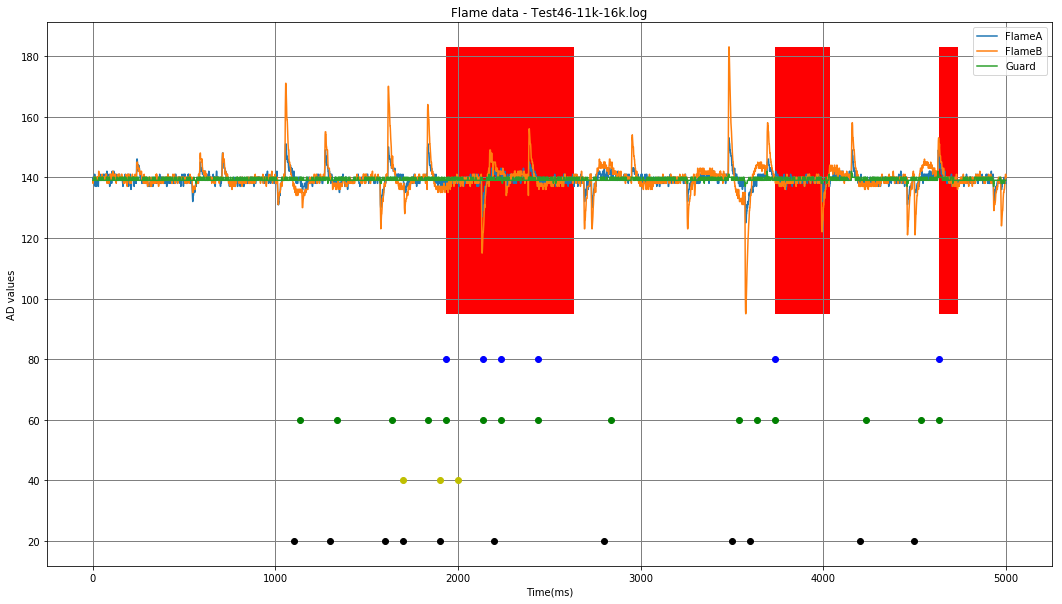

In [21]:
##### import numpy as np
import re

def processFlameData(farr, file):
    
    %matplotlib inline
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    
    ONE_SECOND_LOG = False
    
    # Arrays to be plotted
    CalcSpikePlotArray = []
    CalcAlarmPlotArray = []
    RecSpikePlotArray = []
    
    
    # APPLY FILTERING SCHEME TO ARRAY farr
    # Filtered Flame A signal – To be defined
    
    # indices in our array - one per log file line
    FAidx = 0 # Flame A
    FBidx = 1 # Flame B
    Gidx = 2  # Guard
    iFbv = 3  # Flame bias voltage
    iGbv = 4  # Guard bias voltage
    iAlarm = 5
    iSpike = 7
    
    # Constants - to compute Eauto, Ecross and Eamulr
    # Eamulr   
    # The constant K - assume 50m mode ~ 59570 
    # Gradient = #define SUM_LOF_VAL 77U    
    K = 59570
    Gradient = 77
    # Scalling factors
    Ka = 8
    Kb = 8
    Kg = 8
    
    # distance threshold
    # distThresh = 125
    distThresh = 1000
    # guard scalling factor
    GScallingFactor = 10
    
    FLANDGUBIASLOWERLIMIT = 131
    
    # init Eauto
    Eauto = 0
    Ecross = 0
    Eamulr = 0
    
    k = 0; # our loop counter
    secs = 0; # our seconds counter
    
    # Spike buffer e.g. 3oo5 "three out of five", SpkRegSize = 5, SpikeCount = 3
    SpkRegSize = 5 
    SpikeCount = 3
    SpikeRegister = np.zeros(SpkRegSize, dtype=int)
    
    # Almost alarm definition e.g. 2 out of five in an almost alarm
    AARegSize = 5
    AASpikeCount = 2
    
    # SUMMARY TABLE COUNTERS
    CalculatedAlarms = 0
    CalculatedSpikes = 0    
    CalculatedAlmostAlarms = 0
    RecordedAlarms = 0
    RecordedSpikes = 0
    
    # Record of where calculated spikes and Alarms occured
    #CalcSpikePlotArray = []
    #CalcAlarmPlotArray = []
    
    # plotting
    offset_y = 20
   
    if (ONE_SECOND_LOG == True):
        # One second output header
        padding = re.sub('(.)','*',file)
        print(padding + '**************************')
        print('** ONE SECOND OUTPUT - ' + file + ' **')
        print(padding + '**************************') 
    
    for i in range(farr.shape[0]): # farr.shape e.g. [100, 9]
        Fa = farr[i,FAidx]
        Fb = farr[i,FBidx]
        Gu = farr[i,Gidx]
        Fbv = farr[i,iFbv]
        Gbv = farr[i,iGbv]
        # Correct flame biases
        if(Fbv == 0):
            Fbv = 9
        if(Gbv == 0):
            Gbv = 9 

            
        #print('Fa: %d Fb: %d Gu: %d Fbv: %d Gbv: %d' % (Fa, Fb, Gu, Fbv, Gbv))
        
        # Keep track of recorded alarms
        if (farr[i,iAlarm] == 1):
            RecordedAlarms += 1
        # Keep track of recorded spikes
        if (farr[i,iSpike] == 1):
            RecordedSpikes += 1
            RecSpikePlotArray.append(k)
            
        # Calculate flame signal i.e. flame signal = raw signal – flame bias (applies also to guard)
        Fa = Fa - (FLANDGUBIASLOWERLIMIT + Fbv) 
        Fb = Fb - (FLANDGUBIASLOWERLIMIT + Fbv) 
        Gu = Gu - (FLANDGUBIASLOWERLIMIT + Gbv) 
        
        #print('Fa: %d Fb:%d Gu:%d ' % (Fa, Fb, Gu))
        #print('Eauto += (Ka * Fa * Kb * Fb) (%d * %d * %d * %d)' % (Ka, Fa, Kb, Fb))
        Eauto += (Ka * Fa * Kb * Fb)
        Ecross += np.abs(((Ka * Fa + Kb * Fb) * Kg * Gu * 2))

        #print('Eauto: %d Ecross: %d' % (Eauto, Ecross))
            
        k += 1;
        
        if (k % 100 == 0): # array base 0, one extra on first block of 100
            # increment seconds counter
            # compute and reset
            secs += 1; 
            # 
            Eamulr = (Ecross / 256) * Gradient + K
            spike = 0
            if (Eauto > Eamulr):
                spike = 1;
                CalculatedSpikes += 1
                # Store k for plotting
                CalcSpikePlotArray.append(k)
                
            # shift spike register register to right i.e. copy elements from indexes 0:13 to 1:14 
            SpikeRegister[1:] = SpikeRegister[0:SpkRegSize-1]
            #push the current spike value in
            SpikeRegister[0] = spike
            # decide if we are in alarm
            alarm = 0
            if sum(SpikeRegister) >= SpikeCount:
                alarm = 1
                CalculatedAlarms += 1
                # stored k for plotting
                CalcAlarmPlotArray.append(k)
            
            # Compute almost alarms
            almostAlarm = 0
            if (sum(SpikeRegister[0:AARegSize]) == AASpikeCount):
                CalculatedAlmostAlarms += 1
                almostAlarm = 1
            
            # compute distance function
            distFunc = sum(abs(farr[k-100:k, FAidx] - farr[k-100:k, FBidx]))
            # subtract guard amplitude
            
            # Guard amplitute over 100 samples
            Gamp = max(farr[k-100:k, Gidx]) - min(farr[k-100:k, Gidx])          
            
            # what is the amplitute of Fa and Fb combined, compared to guard, over the interval?
            Amax = max(max(farr[k-100:k, FAidx]), max(farr[k-100:k, FBidx]))
            Amin = min(min(farr[k-100:k, FAidx]), min(farr[k-100:k, FBidx]))
            Famp = Amax - Amin

            
            # compute deltaG function, only if we have a frame size to work with e.g. 3oo5 ~ 5 (SpkRegSize) seconds 
            gInterval = (SpkRegSize * 100) 
            deltaG = 0
            if(k >= gInterval):
                # Guard amplitude over 500 samples (3oo5)
                deltaG = max(farr[k-gInterval:k, Gidx]) - min(farr[k-gInterval:k, Gidx])
                # deltaG /= GScallingFactor
                
            if (ONE_SECOND_LOG == True):
                # print these for now and add as we go along
                vals = (secs, spike, alarm, distFunc, deltaG, Famp, Gamp, Gamp/Famp, Famp/Gamp)
                print('S: %d Spk: %d Alarm: %d Dist: %d DeltaG: %d Famp: %d Gamp: %d Gamp/Famp: %0.2f Famp/Gamp: %0.2f' % vals)
            
            # reset summation
            Eauto = 0
            Ecross = 0
            Eamulr = 0

    # Summary table
    padding = re.sub('(.)','*',file)
    print(padding + '**********************')
    print('** SUMMARY TABLE - ' + file + ' **')
    print(padding + '**********************')
    vals = (AARegSize, AASpikeCount, SpkRegSize, SpikeCount )
    print('Recorded Spikes | Recorded Alarms | Calculated Spikes | Almost Alarms (%doo%d) | Calculated Alarms (%doo%d)' % vals)
    vals = (RecordedSpikes, RecordedAlarms, CalculatedSpikes, CalculatedAlmostAlarms, CalculatedAlarms)
    print('%d               | %d               | %d                 | %d                    | %d                        ' % vals)
    
    # The simulator shall produce a single plot for each file against time showing the following data:
    iIdx = np.arange(1, farr[:,0].size + 1, 1) # iIdx = np.arange(1, iGlfd.size + 1, 1)
    plt.clf()
    figWidthScale = 66 # 1150 points for every 18 inches
    figHeight = 10
    figWidth = 18 # small format # farr[:,FAidx].size / figWidthScale # about 484 inches for a 30 second capture
    plt.figure(figsize=(figWidth,figHeight))
    plt.plot(iIdx, farr[:,FAidx], label='FlameA')
    plt.plot(iIdx, farr[:,FBidx], label='FlameB')
    plt.plot(iIdx, farr[:,Gidx], label='Guard')
    # fill spike state indicator bar
    # spikePolygon(farr, plt)
    # Fill Alarm state indicator bar
    alarmPolygon(farr, plt)    

    # PLOT CALCULATED SPIKES
    # BLACK DOTS
    for i in range(len(CalcSpikePlotArray)):
        plt.plot(CalcSpikePlotArray[i], offset_y,  marker='o', color='k')
        
    # PLOT CALCULATED ALARMS
    # YELLOW DOTS    
    for i in range(len(CalcAlarmPlotArray)):
        plt.plot(CalcAlarmPlotArray[i], offset_y + 20,  marker='o', color='y')
      
    # PLOT RECORDED SPIKES 
    # GREEN DOTS    
    for i in range(len(RecSpikePlotArray)):
        plt.plot(RecSpikePlotArray[i], offset_y + 40,  marker='o', color='g')
        
        k = RecSpikePlotArray[i]
        
        # check if we are in alarm and suppress if distance function above threshold
        if (farr[k,iAlarm] == 1):
            # check absolute distance of last 100 flame a, flame b samples
            distFunc = sum(abs(farr[k-100:k, FAidx] - farr[k-100:k, FBidx]))
            # gDist = sum(abs(farr[k-100:k, Gidx] - farr[k-100:k, Gidx]))
            gDist = max(farr[k-100:k, Gidx]) - min(farr[k-100:k, Gidx])
            # GScallingFactor
            # then scale to 255 based on last 5 seconds
            sFactor = getScallingFactor(k, farr, FAidx, FBidx, Gidx, SpkRegSize * 100, GScallingFactor, SpkRegSize) # e.g. for 3oo5, look at last 5 seconds
            distFunc *= sFactor
            print('sFactor: %d distFunc * sFactor: %d gDist: %d' % (sFactor, distFunc, gDist))
            if(distFunc > distThresh): # distance above threshold, suppress
                # yes, suppress spike
                plt.plot(RecSpikePlotArray[i], offset_y + 60,  marker='o', color='b')     
            
    plt.xlabel('Time(ms)')
    plt.ylabel('AD values')
    plt.title("Flame data - " + file)
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=1)
    plt.show() 
    img_file = os.getcwd() + '\\' + file + '.png'
    #filepath = os.getcwd() + '\\filename.txt
    #plt.savefig()
        
    # clear arrays
  

path = "data/dev-set/"
pattern = "*.log"
logs = getLogfiles(path, pattern)
for log in logs:
    arr = processLog(path, log)
    # for testing filtering algorithms
    processFlameData(arr, log)

 